In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch
import torch.nn as nn

# Define a simple MLP model
class SimpleMLP(nn.Module):
    def __init__(self, input_size=10, hidden_size=20, output_size=2):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# Instantiate the model
model = SimpleMLP()

model_path = 'simple_mlp.pth'
try:
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded existing model from {model_path}")
except FileNotFoundError:
    print("No existing model found, training new model...")

    # Test the model with random data
    batch_size = 4
    input_tensor = torch.randn(batch_size, 10)
    output = model(input_tensor)

    print("Model architecture:")
    print(model)
    print("\nTest input shape:", input_tensor.shape)
    print("Test output shape:", output.shape)

    # Optional: Brief training on random data
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Generate random training data
    X = torch.randn(100, 10)  # 100 samples
    y = torch.randn(100, 2)   # Random targets

    # Train for a few epochs
    for epoch in range(5):
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        if epoch % 1 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

    # Save the model after training
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")


Loaded existing model from simple_mlp.pth


In [7]:
# Input to the model
x = torch.randn(batch_size, 10, requires_grad=True)
torch_out = model(x)

# Export the model
torch.onnx.export(model,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "simple_mlp.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=20,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [9]:
import onnx

onnx_model = onnx.load("simple_mlp.onnx")
onnx.checker.check_model(onnx_model)

In [10]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession("simple_mlp.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {'input': to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


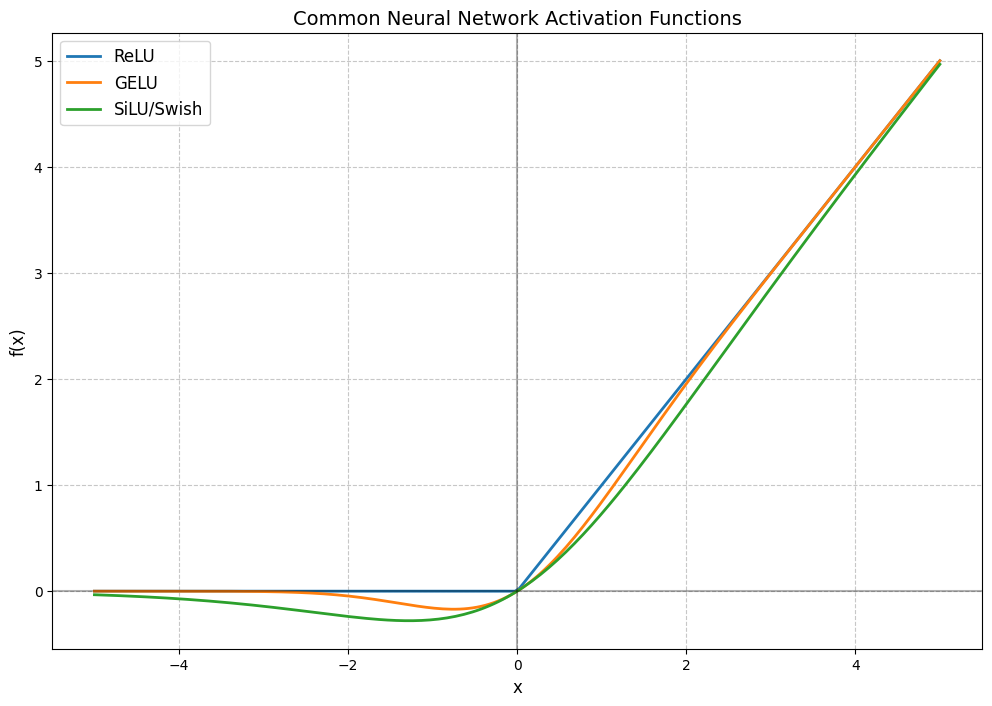

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Create input values
x = np.linspace(-5, 5, 200)

# Calculate activation functions
relu = np.maximum(0, x)
leaky_relu = np.where(x > 0, x, 0.1 * x)
sigmoid = 1 / (1 + np.exp(-x))
tanh = np.tanh(x)
gelu = 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))
silu = x * sigmoid

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(x, relu, label='ReLU', linewidth=2)
# plt.plot(x, leaky_relu, label='Leaky ReLU (α=0.1)', linewidth=2)
# plt.plot(x, sigmoid, label='Sigmoid', linewidth=2)
# plt.plot(x, tanh, label='Tanh', linewidth=2)
plt.plot(x, gelu, label='GELU', linewidth=2)
plt.plot(x, silu, label='SiLU/Swish', linewidth=2)

# Add grid and styling
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.title('Common Neural Network Activation Functions', fontsize=14)
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)

plt.show()
